<a href="https://colab.research.google.com/github/Hramchenko/ML/blob/master/adversarial_autoenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision
import torch

In [30]:
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
print(device)

Device Tesla K80
cuda:0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import os 

%matplotlib inline

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot        

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [0]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
lr = 0.0001
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_data, _ = next(iter(test_loader))

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
G = FullyConnected([28*28, 1024, 128, 16, 16, 128, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh()).to(device)
D = FullyConnected([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True).to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
#D_optimizer = optim.SGD(D.parameters(), lr=1e-4)


In [39]:
from random import random
random()

0.9272137317456273

In [0]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [0]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [0]:
from random import random

def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        data = data.to(device)
        G.zero_grad()
        
        if (random() < 1) or (batch_idx < 2):
          D.zero_grad()
          enc = G(torch.flatten(data, 1))
          #print(enc.shape)
          fake_pred = D(enc)
          true_pred = D(data)
        
          fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
          true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
          D_loss = 0.5*(fake_loss + true_loss)
        
          D_loss.backward()
          D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        
        enc = G(torch.flatten(data, 1))
        fake_pred = D(enc)
        
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        #G_loss = F.mse_loss(enc, torch.flatten(data, 1))
        
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [0]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            enc = G(torch.flatten(data, 1))
            fake_pred = D(enc)
            true_pred = D(data)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

#    fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
#    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    enc = G(fixed_data.flatten(1).to(device))[0:50, :]
    #print(enc.shape)
    ae_data = enc.view(-1, 1, 28, 28).data.cpu().numpy()
    plot_mnist(ae_data, (5, 10))
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

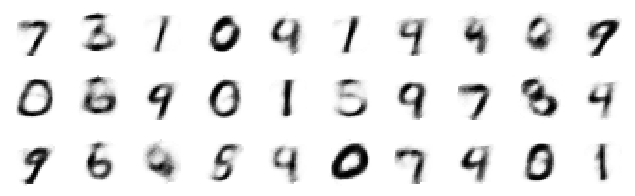

In [48]:
    enc = G(fixed_data.flatten(1).to(device))[0:30, :]
    #enc = fixed_data.flatten(1).to(device)[0:30, :]
    #print(enc.shape)
    ae_data = enc.view(-1, 1, 28, 28).data.cpu().numpy()
    plot_mnist(ae_data, (3, 10))
   

Train Epoch: 1 [0/50000 (0%)]	Losses G: 6.6274, D: 0.0297
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 6.2665, D: 0.1854
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 9.8624, D: 0.0162


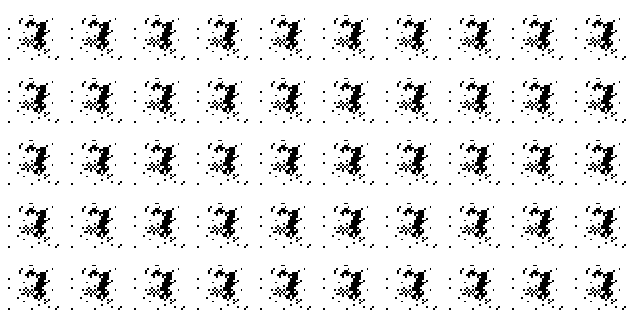

Test losses. G: 9.5193, D: 0.0053
Train Epoch: 2 [0/50000 (0%)]	Losses G: 9.4604, D: 0.0158
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 12.2445, D: 0.0035
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 13.1800, D: 0.0011


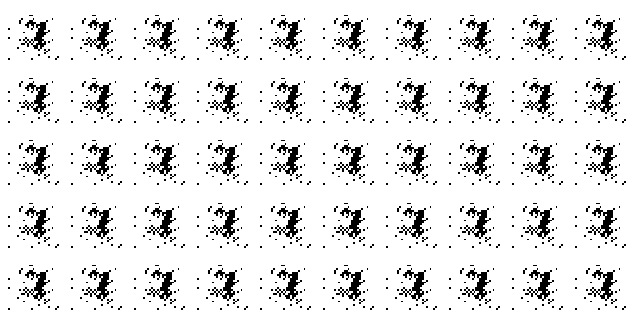

Test losses. G: 12.2287, D: 0.0014
Train Epoch: 3 [0/50000 (0%)]	Losses G: 12.7092, D: 0.0055


KeyboardInterrupt: ignored

In [49]:
for epoch in range(1, 200):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)